<a href="https://colab.research.google.com/github/DarshanPatel0919/Deep-Learning/blob/master/LabAssignment7_201701436.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Modules**

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras import regularizers, activations
from tensorflow.keras import initializers as init
from tensorflow.keras import optimizers as opti
from tensorflow.keras import backend as K


import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, validation_curve 
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as mse_fn


import numpy as np
import pandas as pd
from time import time 
from matplotlib import pyplot as plt
from google.colab import drive

from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

# Helper Functions

In [ ]:
def myplot(hist, metric= 'mse', st= 0, en= -1, label= 'Train'):
  if en == -1:
    en = len(hist[metric])
  
  st = int(st)
  en = int(en)

  x = np.linspace(st+1,en,en-st)
  acc = hist[metric][st:en]

  plt.plot(x,acc,label= label)

  plt.xlabel('Epochs')
  plt.ylabel(metric)

def plot_image(X ,T = []):
  n = len(X)
  if len(T) == 0:
    T = ['']*n
  plt.figure(figsize=(2*n + 1,2))
  for i in range(n):
    plt.subplot(1,n,i+1)
    im = X[i].reshape(28,28)*255
    im = np.clip(im,0,255)
    plt.imshow(im,'gray')
    plt.title(T[i])
    plt.axis('off')

#**Data Pre-processing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/My Drive/Deep Learning/mnist-fashion/'

In [ ]:
train = pd.read_csv(root+'fashion-mnist_train.csv')
test = pd.read_csv(root+'fashion-mnist_test.csv')

X_TRAIN = np.array(train)[:,1:]
X_TEST =  np.array(test)[:,1:]

X_TRAIN.shape, X_TEST.shape

In [ ]:
#adding noise of standard deviation 50
#factor which is multiplied is standard_deviation 

#X_TRAIN has 60000 images each of dimension 784 (28X28) --> (60000,784)
#X_TEST has 10000 images each of dimension 784 (28X28) --> (10000,784)

X_TRAIN_NOISY = X_TRAIN + 10*np.random.normal(size=X_TRAIN.shape)
X_TEST_NOISY = X_TEST + 10*np.random.normal(size=X_TEST.shape)

#to make sure values are in (0,1) range

X_TRAIN_NOISY = X_TRAIN_NOISY/255.0
X_TEST_NOISY = X_TEST_NOISY/255.0

X_TEST = X_TEST/255.0
X_TRAIN = X_TRAIN/255.0

X_TRAIN_NOISY = np.clip(X_TRAIN_NOISY,0,1)
X_TEST_NOISY = np.clip(X_TEST_NOISY,0,1)

images = [X_TRAIN_NOISY[10], X_TRAIN[10]]
titles = ['noisy','true']
plot_image(images,titles)

# **Build Function**

* dim : dimension architechture as list **default** = [256,32,256,784]
* ini : initial weights for each layers, **default** = 'glorot_uniform'

In [ ]:
def build(dim= [256,64,256,784], ini= 'glorot_uniform'):
  
  model = Sequential()

  ### Input Layer
  model.add(keras.Input(shape=(784,)))

  ### Hidden Layers
  for i in range(len(dim)):
      model.add(Dense(dim[i], 'relu', 1, ini))

  model.compile(loss='mse', optimizer='adam', metrics=['mse'])
  return model

# **Train Function**

In [ ]:
def train(model,epochs=50, batch_size=2000):
  return model.fit(X_TRAIN_NOISY, X_TRAIN, epochs=epochs, batch_size=batch_size, verbose=0).history

# Tying Weight Function



In [ ]:
class DenseTied(Layer):
    def __init__(self, units, activation=None, tied_to=None, **kwargs):
        self.tied_to = tied_to
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super().__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
                
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = K.transpose(self.tied_to.kernel)
        self._non_trainable_weights.append(self.kernel)
        
        self.bias = self.add_weight(shape=(self.units,),
                                    initializer=init.Zeros(),
                                    name='bias')
        
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        output = K.bias_add(output, self.bias, data_format='channels_last')
        output = self.activation(output)
        return output

def custom_tied_undercomplete(fn = 'relu', ini = 'glorot_uniform'):
  model = Sequential()

  x1 = Dense(256, fn, 1, ini,  input_dim=784)
  model.add(x1)
  x2 = Dense(64, fn, 1, ini)
  model.add(x2)
  x3 = DenseTied(256, fn, tied_to=x2)
  model.add(x3)
  x4 = Dense(784, fn, 1, ini)
  model.add(x4)
  
  model.compile(loss='mse', optimizer='adam', metrics=['mse'])
  return model

def custom_tied_undercomplete2(fn = 'relu', ini = 'glorot_uniform'):
  model = Sequential()

  x1 = Dense(256, fn, 1, ini,  input_dim=784)
  model.add(x1)
  x2 = Dense(64, fn, 1, ini)
  model.add(x2)
  x3 = DenseTied(256, fn, tied_to=x2)
  model.add(x3)
  x4 = DenseTied(784, fn, tied_to=x1)
  model.add(x4)
  
  model.compile(loss='mse', optimizer='adam', metrics=['mse'])
  return model

def custom_tied_overcomplete(fn = 'relu', ini = 'glorot_uniform'):
  model = Sequential()

  reg = regularizers.L2(0.0001)
  x1 = Dense(1296, fn, 1, ini, kernel_regularizer= reg, bias_regularizer=reg, input_dim=784)
  model.add(x1)
  x2 = DenseTied(784, fn, tied_to=x1)
  model.add(x2)
  
  model.compile(loss='mse', optimizer='adam', metrics=['mse'])
  return model

# **Undercomplete Autoencoder**


##Architecture

In [ ]:
#===================  5 Layers ===================#
layers = [256,128,64,128,256,784]
under5 = build(layers)
history5 = train(under5)

#===================  4 Layers ===================#
layers = [256,32,32,256,784]
under4 = build(layers)
history4 = train(under4)

#===================  3 Layers ===================#
layers = [256,128,256,784]
under3 = build(layers)
st = time()
history3 = train(under3)
en = time()
t_wo_tying = en - st

In [ ]:
myplot(history3,st=1,label='3 layer')
myplot(history4,st=1,label='4 layer')
myplot(history5,st=1,label='5 layer')
plt.title('Undercomplete')
plt.legend(loc='best')
plt.show()

**Observation**
* After trying saveral different architectures by changing nodes in each layers for each model, this result is represents the average case.
* It appears that 3 layer and 5 layer models show better results because of the symmentry of weight matrices in their respective architectures, where as there is assymetry in 4 layer architecture.
* Also 3 Layer architecture is showing the best results for this case. Implying that shrinking the bottleneck(latent layers) too much also affects the performance of the auto-encoder.
* Hence 3 layer architecture is the just right fit for this case.

In [ ]:
# Sample results
i = np.random.randint(X_TEST.shape[0])

y5 = under5.predict(np.reshape(X_TEST_NOISY[i],(1,784)))
y4 = under4.predict(np.reshape(X_TEST_NOISY[i],(1,784)))
y3 = under3.predict(np.reshape(X_TEST_NOISY[i],(1,784)))


print('                             Undercomplete Autoencoder\n')
images = [X_TEST_NOISY[i], X_TEST[i], y3,y4, y5]
titles = ['noisy','true','Layer-3','Layer-4','Layer-5']
plot_image(images,titles)
plt.show()

**Ovservaton**
* Here, most of the noise is removed from images. But the resulting images are a bit distorted.
* We can see that image reconstucted by 3-Layer model is very close to the true image.
* On the other hand image constructed by the 4-Layer is worst here.

##Varying Initial Weights

In [ ]:
tf.random.set_seed(22)
types = [init.GlorotUniform(), init.GlorotNormal(), init.HeNormal()]
names = ['GlorotUniform','GlorotNormal','HeNormal']

In [ ]:
Model, Hist, t= {},{},{}

for i in range(len(types)):
  Model[i] = build(layers, ini = types[i])
  Hist[i] = train(Model[i])

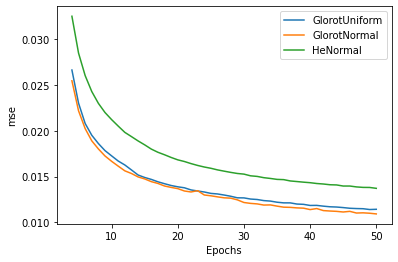

In [166]:
for i in range(len(types)):
  myplot(Hist[i], st=3, label=names[i])

plt.legend(loc='best')
plt.show()

**Observation**
* Looking at the mse vs epochs graph, we conclude that GlorotUniform and GlorotNormal are better weight initializer for this particular case
* Also, after trying some different seed values i found that 22 works very good.
* Note that initializing with all zeros and all ones results in no training at all, since the range of the data is very small, bias = 1 results in major effect during training.

In [ ]:
# Sample results
i = np.random.randint(X_TEST.shape[0])
y = [0]*len(types)

for j in range(len(types)):
  y[j] = Model[j].predict(np.reshape(X_TEST_NOISY[i],(1,784)))

print('                             Undercomplete Autoencoder\n')
images = [X_TEST_NOISY[i], X_TEST[i]] + y
titles = ['noisy','true'] + names
plot_image(images,titles)
plt.show()

##Tying Weights

In [187]:
model = custom_tied_undercomplete()
st=time()
hist = train(model)
en=time()
t_tying = en - st

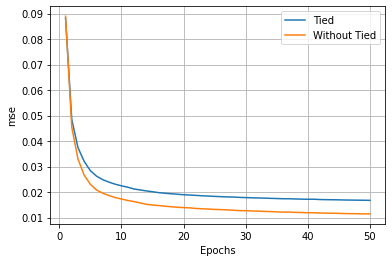

Time taken without tying = 139.54977345466614
Time taken with tying = 127.98547887802124


In [188]:
myplot(hist,label='Tied')
myplot(Hist[0],label='Without Tied')
plt.legend(loc='best')
plt.grid()
plt.show()

print('Time taken without tying =',t_wo_tying)
print('Time taken with tying =',t_tying)

* This is the result of tying only two layers of the architecture.
* We can see there is not significant, amount of increase in the time speedup, but as the tying layers increase speedup increases as well
* There is a trade off though, as tying layers increase the performace is compromised because of lesser training. (Shown Below)  

In [200]:
model = custom_tied_undercomplete2()
st=time()
hist = train(model)
en=time()
t_tying = en - st

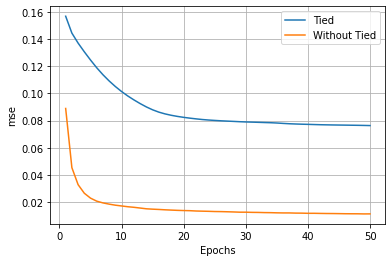

Time taken with tying = 109.5794529914856


In [203]:
myplot(hist,label='Tied')
myplot(Hist[0],label='Without Tied')
plt.legend(loc='best')
plt.grid()
plt.show()
print('Time taken with tying =',t_tying)

* The speedup is better, but the performance declines because of less information being learned because of the tied layers.

# **Overcomplete Autoencoder**


##Architecture

In [191]:
epoch = 40
batch = 6000 

#===================  5 Layers ===================#
layers = [1024,1296,1024,784]
under5 = build(layers)
history5 = train(under5,epoch,batch)

#===================  4 Layers ===================#
layers = [1024,1296,784]
under4 = build(layers)
history4 = train(under4,epoch,batch)

#===================  3 Layers ===================#
layers = [1296,784]
under3 = build(layers)
st = time()
history3 = train(under3,epoch,batch)
en = time()
t_wo_tying = en - st

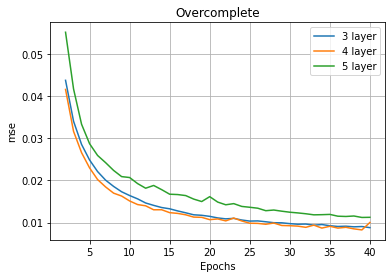

In [194]:
myplot(history3,st=1,label='3 layer')
myplot(history4,st=1,label='4 layer')
myplot(history5,st=1,label='5 layer')
plt.title('Overcomplete')
plt.legend(loc='best')
plt.grid()
plt.show()

**Observation**
* Comparing to undercomplete autoencoder, this results are better acknowledging the fact that epoch = 40 are even lesser than training before.
* But the training curve is unstable which might be stabilized using regulariation
* Also the curve of 3 layer autoencoder is smoothest among all models, hence it is the best model.

                             Undercomplete Autoencoder



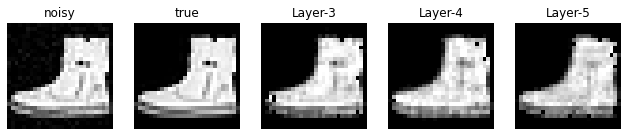

In [198]:
# Sample results
i = np.random.randint(X_TEST.shape[0])

y5 = under5.predict(np.reshape(X_TEST_NOISY[i],(1,784)))
y4 = under4.predict(np.reshape(X_TEST_NOISY[i],(1,784)))
y3 = under3.predict(np.reshape(X_TEST_NOISY[i],(1,784)))


print('                             Undercomplete Autoencoder\n')
images = [X_TEST_NOISY[i], X_TEST[i], y3,y4, y5]
titles = ['noisy','true','Layer-3','Layer-4','Layer-5']
plot_image(images,titles)
plt.show()

**Ovservaton**
* Here, most of the noise is removed from images. But the resulting images are a bit distorted.
* We can see that image reconstucted by 3-Layer model is very close to the true image.

##Varying Initial Weights

In [205]:
tf.random.set_seed(22)
types = [init.GlorotUniform(), init.GlorotNormal(), init.HeNormal()]
names = ['GlorotUniform','GlorotNormal','HeNormal']

In [206]:
Model, Hist, t= {},{},{}

for i in range(len(types)):
  Model[i] = build(layers, ini = types[i])
  Hist[i] = train(Model[i])

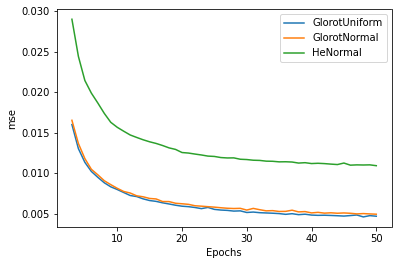

In [207]:
for i in range(len(types)):
  myplot(Hist[i], st=2, label=names[i])

plt.legend(loc='best')
plt.show()

**Observation**
* The results are similar to undercomplete auto-encoder

                             Undercomplete Autoencoder



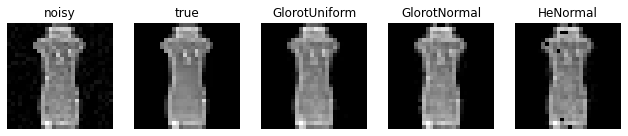

In [209]:
# Sample results
i = np.random.randint(X_TEST.shape[0])
y = [0]*len(types)

for j in range(len(types)):
  y[j] = Model[j].predict(np.reshape(X_TEST_NOISY[i],(1,784)))

print('                             Undercomplete Autoencoder\n')
images = [X_TEST_NOISY[i], X_TEST[i]] + y
titles = ['noisy','true'] + names
plot_image(images,titles)
plt.show()

##Tying Weights

In [210]:
model = custom_tied_overcomplete()
st=time()
hist = train(model)
en=time()
t_tying = en - st

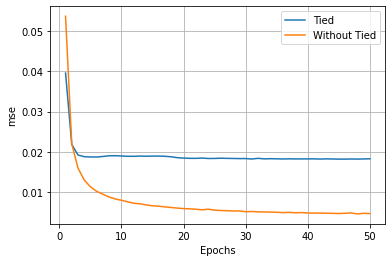

In [212]:
myplot(hist,label='Tied')
myplot(Hist[0],label='Without Tied')
plt.legend(loc='best')
plt.grid()
plt.show()

In [214]:
t_wo_tying

406.13338589668274

* The performance results are way better than undercomplete tying auto encoders. Convergence of tying is also very faster than the case of undercomplete autoencoder. 
* The time taken is more because of larger layers.